# Yield Curve Construction - Deep Dive into Bootstrap Algorithm

This notebook provides a **step-by-step breakdown** of how the `yield_curve.py` module constructs zero-coupon curves using the bootstrap method. We'll trace through each calculation, showing mini test cases that reveal exactly what the code is doing internally.

## What We'll Cover

1. **Discount Factors & Spot Rates**: The mathematical foundation
2. **Zero-Coupon Bootstrap**: Direct extraction from T-Bills
3. **Coupon Bond Bootstrap**: Iterative solving using known discount factors
4. **Spline Interpolation**: Creating smooth curves from discrete points
5. **Rate Extraction**: Getting rates at arbitrary maturities
6. **Validation**: Verifying the bootstrap accuracy

---

In [15]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.interpolate import CubicSpline
import warnings
warnings.filterwarnings('ignore')

# Add src folder to path to import our module
sys.path.insert(0, str(Path.cwd() / 'src'))

# Remove any cached modules to ensure fresh import
if 'yield_curve' in sys.modules:
    del sys.modules['yield_curve']

from yield_curve import YieldCurve, Instrument

print("✓ All libraries imported successfully")
print(f"✓ YieldCurve module loaded")
print(f"✓ NumPy version: {np.__version__}")
print(f"✓ Pandas version: {pd.__version__}")

✓ All libraries imported successfully
✓ YieldCurve module loaded
✓ NumPy version: 2.4.2
✓ Pandas version: 3.0.0


## 1. Understanding Discount Factors & Spot Rates

The **foundation** of yield curve construction is the relationship between:
- **Discount Factor (DF)**: How much $1 received at time T is worth today
- **Spot Rate (Z)**: The zero-coupon interest rate at maturity T
- **Present Value**: Converting future cash flows to today's value

### Mathematical Relationships

Given a spot rate Z at maturity T:
$$DF(T) = \frac{1}{(1 + Z)^T}$$

Rearranging to get spot rate from DF:
$$Z = \left(\frac{1}{DF(T)}\right)^{1/T} - 1$$

This is exactly what `yield_curve.py` does in the `_df_to_spot_rate()` method!

In [16]:
print("=" * 80)
print("MINI TEST CASE 1: Converting Between Discount Factors and Spot Rates")
print("=" * 80)

# Given: A 2-year spot rate of 3.5%
T = 2.0
spot_rate_input = 0.035

print(f"\nInput:")
print(f"  Maturity (T) = {T} years")
print(f"  Spot Rate (Z) = {spot_rate_input*100:.2f}%")

# Step 1: Calculate DF from spot rate (what the module does during bootstrap)
df_calculated = 1.0 / ((1 + spot_rate_input) ** T)
print(f"\nStep 1: Calculate DF from Spot Rate")
print(f"  Formula: DF(T) = 1 / (1 + Z)^T")
print(f"  DF(2.0) = 1 / (1 + {spot_rate_input})^{T}")
print(f"  DF(2.0) = 1 / {(1 + spot_rate_input)**T:.8f}")
print(f"  DF(2.0) = {df_calculated:.8f}")

# Step 2: This means...
principal = 100.0
pv_of_principal = principal * df_calculated
print(f"\nStep 2: What does this DF mean?")
print(f"  $100 received in {T} years is worth ${pv_of_principal:.2f} today")
print(f"  The discount is {principal - pv_of_principal:.2f} or {(1 - df_calculated)*100:.2f}%")

# Step 3: Convert back from DF to Spot Rate (inverse calculation)
# This is exactly what _df_to_spot_rate() does
spot_rate_recovered = (1.0 / df_calculated) ** (1.0 / T) - 1.0
print(f"\nStep 3: Convert DF back to Spot Rate (verify roundtrip)")
print(f"  Formula: Z = (1/DF)^(1/T) - 1")
print(f"  Z = (1/{df_calculated:.8f})^(1/{T}) - 1")
print(f"  Z = {(1.0/df_calculated):.8f}^({1.0/T:.1f}) - 1")
print(f"  Z = {spot_rate_recovered*100:.6f}%")
print(f"  ✓ Recovered original rate: {abs(spot_rate_recovered - spot_rate_input) < 1e-10}")

# Mini test case with multiple maturities
print(f"\n{'-' * 80}")
print("Mini Test: Spot Curve Conversion")
print(f"{'-' * 80}")

maturities = np.array([0.5, 1.0, 1.5, 2.0, 3.0, 5.0])
spot_rates = np.array([0.025, 0.030, 0.033, 0.035, 0.038, 0.042])

conversion_df = pd.DataFrame({
    'Maturity (Y)': maturities,
    'Spot Rate (%)': spot_rates * 100,
    'DF = 1/(1+Z)^T': 1.0 / ((1 + spot_rates) ** maturities),
    '$100 Today Worth': 100 * (1.0 / ((1 + spot_rates) ** maturities)),
})

print(conversion_df.to_string(index=False))
print("\nObservation: As maturity increases, discount factors decrease (money is worth less in future)")

MINI TEST CASE 1: Converting Between Discount Factors and Spot Rates

Input:
  Maturity (T) = 2.0 years
  Spot Rate (Z) = 3.50%

Step 1: Calculate DF from Spot Rate
  Formula: DF(T) = 1 / (1 + Z)^T
  DF(2.0) = 1 / (1 + 0.035)^2.0
  DF(2.0) = 1 / 1.07122500
  DF(2.0) = 0.93351070

Step 2: What does this DF mean?
  $100 received in 2.0 years is worth $93.35 today
  The discount is 6.65 or 6.65%

Step 3: Convert DF back to Spot Rate (verify roundtrip)
  Formula: Z = (1/DF)^(1/T) - 1
  Z = (1/0.93351070)^(1/2.0) - 1
  Z = 1.07122500^(0.5) - 1
  Z = 3.500000%
  ✓ Recovered original rate: True

--------------------------------------------------------------------------------
Mini Test: Spot Curve Conversion
--------------------------------------------------------------------------------
 Maturity (Y)  Spot Rate (%)  DF = 1/(1+Z)^T  $100 Today Worth
          0.5            2.5        0.987730         98.772960
          1.0            3.0        0.970874         97.087379
          1.5       

## 2. Zero-Coupon Bond Bootstrap (The Simplest Case)

**Zero-coupon bonds** (like T-Bills) have **no coupon payments**. They are sold at a discount and redeemed at par (face value).

### The Key Insight

For a zero-coupon bond:
- **Price** = Par × **Discount Factor**

Therefore:
$$DF = \frac{\text{Price}}{\text{Par}}$$

This is the **simplest bootstrap calculation** - it's just division!

### Why This Works

A zero-coupon bond has a single cash flow at maturity. If you pay $97 today for a $100 bond maturing in 1 year, then:
- The discount factor is exactly 97/100 = 0.97
- This represents the market's valuation of $1 received in 1 year
- Convert to spot rate: Z = (1/0.97) - 1 = 3.09%

**This is what `_bootstrap_first_instrument()` does when `coupon_rate = 0`!**

In [17]:
print("\n" + "=" * 80)
print("MINI TEST CASE 2: Zero-Coupon Bond Bootstrap (T-Bills)")
print("=" * 80)

# Create a simple zero-coupon instrument
print("\nScenario: We have 4 T-Bills with different maturities and prices")
print("-" * 80)

zero_coupon_instruments_data = [
    {"maturity": 0.083, "coupon": 0.00, "price": 99.80, "par": 100},  # 1 month
    {"maturity": 0.25, "coupon": 0.00, "price": 99.40, "par": 100},   # 3 months
    {"maturity": 0.50, "coupon": 0.00, "price": 98.80, "par": 100},   # 6 months
    {"maturity": 1.00, "coupon": 0.00, "price": 97.60, "par": 100},   # 1 year
]

bootstrap_steps = []

for i, inst in enumerate(zero_coupon_instruments_data, 1):
    T = inst["maturity"]
    price = inst["price"]
    par = inst["par"]
    
    # BOOTSTRAP STEP: Calculate DF directly from price
    df = price / par
    
    # Convert to spot rate
    spot_rate = (1.0 / df) ** (1.0 / T) - 1.0
    
    print(f"\nInstrument {i}: {T}-year T-Bill")
    print(f"  Market Price: ${price:.2f} (per $100 par)")
    print(f"  Bootstrap Step: DF = Price / Par = {price}/{par} = {df:.8f}")
    print(f"  Spot Rate: Z = (1/DF)^(1/T) - 1 = {spot_rate*100:.6f}%")
    print(f"  Interpretation: $1 received in {T}Y is worth ${df:.8f} today")
    
    bootstrap_steps.append({
        'Maturity (Y)': T,
        'Price': price,
        'Discount Factor': df,
        'Spot Rate (%)': spot_rate * 100,
        'Annualized Return': f"{spot_rate*100:.4f}%"
    })

bootstrap_df = pd.DataFrame(bootstrap_steps)
print(f"\n{'-' * 80}")
print("Summary of Zero-Coupon Bootstrap:")
print(bootstrap_df.to_string(index=False))

print(f"\n✓ This is EXACTLY what the module's _bootstrap_first_instrument() does!")
print(f"✓ The code path is: Instrument → _bootstrap_first_instrument() → df = price / par")

# Now verify with actual Instrument objects
print(f"\n{'-' * 80}")
print("Verification: Creating actual Instrument objects and bootstrapping")
print("-" * 80)

# Create instruments using the Instrument class
instruments = [
    Instrument(maturity=0.083, coupon_rate=0.00, price=99.80, coupon_frequency=1),
    Instrument(maturity=0.25, coupon_rate=0.00, price=99.40, coupon_frequency=1),
    Instrument(maturity=0.50, coupon_rate=0.00, price=98.80, coupon_frequency=1),
    Instrument(maturity=1.00, coupon_rate=0.00, price=97.60, coupon_frequency=1),
]

# Bootstrap the curve
curve = YieldCurve()
curve.bootstrap(instruments)

# Display results
print("\nBootstrapped Curve:")
print(curve.print_curve())

# Compare with manual calculations
comparison = pd.DataFrame({
    'Maturity (Y)': curve.maturities,
    'Manual Calc (%)': [r*100 for r in bootstrap_df['Spot Rate (%)']],
    'Module Result (%)': [r*100 for r in curve.spot_rates],
    'Match': [abs(m - c*100) < 0.001 for m, c in zip(bootstrap_df['Spot Rate (%)'], curve.spot_rates)]
})

print("\nComparison of Manual vs Module Results:")
print(comparison.to_string(index=False))


MINI TEST CASE 2: Zero-Coupon Bond Bootstrap (T-Bills)

Scenario: We have 4 T-Bills with different maturities and prices
--------------------------------------------------------------------------------

Instrument 1: 0.083-year T-Bill
  Market Price: $99.80 (per $100 par)
  Bootstrap Step: DF = Price / Par = 99.8/100 = 0.99800000
  Spot Rate: Z = (1/DF)^(1/T) - 1 = 2.441377%
  Interpretation: $1 received in 0.083Y is worth $0.99800000 today

Instrument 2: 0.25-year T-Bill
  Market Price: $99.40 (per $100 par)
  Bootstrap Step: DF = Price / Par = 99.4/100 = 0.99400000
  Spot Rate: Z = (1/DF)^(1/T) - 1 = 2.436437%
  Interpretation: $1 received in 0.25Y is worth $0.99400000 today

Instrument 3: 0.5-year T-Bill
  Market Price: $98.80 (per $100 par)
  Bootstrap Step: DF = Price / Par = 98.8/100 = 0.98800000
  Spot Rate: Z = (1/DF)^(1/T) - 1 = 2.443902%
  Interpretation: $1 received in 0.5Y is worth $0.98800000 today

Instrument 4: 1.0-year T-Bill
  Market Price: $97.60 (per $100 par)
  Boo

## 3. Coupon Bond Bootstrap (The Recursive Step)

This is where the **bootstrap method gets powerful**. When you have **coupon-bearing bonds**, you can't directly calculate the DF because there are multiple cash flows.

### The Bootstrap Equation

For a coupon bond with cash flows at times t₁, t₂, ..., T:

$$\text{Price} = \sum_{i=1}^{n-1} C_i \times DF(t_i) + (C_n + \text{Par}) \times DF(T)$$

Where:
- The first (n-1) terms use **already-known** discount factors from previously bootstrapped instruments
- The last term uses the **unknown** discount factor at maturity T

### Solving for the Unknown DF

Rearranging to solve for DF(T):

$$DF(T) = \frac{\text{Price} - \sum_{i=1}^{n-1} C_i \times DF(t_i)}{C_n + \text{Par}}$$

**This is exactly what `_bootstrap_instrument()` does!**

The key insight: **We only have one unknown**, so simple algebra solves it!

In [18]:
print("\n" + "=" * 80)
print("MINI TEST CASE 3: Coupon Bond Bootstrap (The Recursive Step)")
print("=" * 80)

print("\n" + "="*80)
print("SCENARIO: We've already bootstrapped years 0.5 and 1.0")
print("          Now bootstrap a 1.5-year bond with 3% coupon, semi-annual payments")
print("="*80)

# Previously bootstrapped DFs (from zero-coupon instruments)
known_dfs = {
    0.5: 0.9878,  # From 6-month T-Bill
    1.0: 0.9759,  # From 1-year T-Bill
}

print("\nKNOWN Information:")
print(f"  DF(0.5Y) = {known_dfs[0.5]:.8f}  ← from bootstrapped 6-month T-Bill")
print(f"  DF(1.0Y) = {known_dfs[1.0]:.8f}  ← from bootstrapped 1-year T-Bill")

# The new bond we're bootstrapping
maturity_new = 1.5
coupon_rate = 0.03
par_value = 100
frequency = 2  # Semi-annual
price_market = 100.50

print(f"\nNEW Bond Details:")
print(f"  Maturity: {maturity_new} years")
print(f"  Coupon Rate: {coupon_rate*100}%")
print(f"  Payment Frequency: {frequency} times per year")
print(f"  Par Value: ${par_value}")
print(f"  Market Price: ${price_market:.2f}")

# Calculate cash flow schedule
payment_times = []
payment_amounts = []
coupon_payment = (coupon_rate * par_value) / frequency

time_step = 1.0 / frequency
current_time = time_step

while current_time <= maturity_new - 1e-6:
    if abs(current_time - maturity_new) < 1e-6:  # Final payment
        payment_times.append(current_time)
        payment_amounts.append(coupon_payment + par_value)
        break
    else:  # Regular coupon
        payment_times.append(current_time)
        payment_amounts.append(coupon_payment)
    current_time += time_step

# Add final payment if not already added
if abs(current_time - maturity_new) >= 1e-6:
    payment_times.append(maturity_new)
    payment_amounts.append(coupon_payment + par_value)

print(f"\nCash Flow Schedule:")
print(f"{'Time (Y)':>10} | {'Payment Type':>20} | {'Amount ($)':>12}")
print("-" * 45)
for t, amt in zip(payment_times, payment_amounts):
    ptype = "Principal + Coupon" if amt > coupon_payment + 5 else "Coupon"
    print(f"{t:>10.2f} | {ptype:>20} | {amt:>12.2f}")

# Bootstrap Step 1: Calculate PV of known payments
print(f"\n{'='*80}")
print("BOOTSTRAP CALCULATION:")
print(f"{'='*80}")

pv_known_payments = 0.0
print(f"\nStep 1: Calculate PV of coupon payments before maturity (using known DFs)")
print(f"  {'-'*76}")

for i, (t, amt) in enumerate(zip(payment_times, payment_amounts)):
    if t < maturity_new - 1e-6:  # Not the final payment
        df = known_dfs.get(t)
        if df is None:
            # For times not in known_dfs, interpolate
            df = np.interp(t, list(known_dfs.keys()), list(known_dfs.values()))
        
        pv = amt * df
        pv_known_payments += pv
        print(f"  PV of ${amt:>7.2f} at {t}Y: ${amt:.2f} × {df:.8f} = ${pv:.4f}")
    else:
        # This is the final payment - we'll solve for its DF
        final_time = t
        final_payment = amt
        print(f"  *** Final payment of ${final_payment:.2f} at {final_time}Y (UNKNOWN DF) ***")

print(f"\n  Total PV of known payments: ${pv_known_payments:.4f}")

# Step 2: Solve for unknown DF
print(f"\nStep 2: Solve for DF at maturity ({maturity_new}Y)")
print(f"  {'-'*76}")
print(f"  Bond pricing equation:")
print(f"    Price = PV(known payments) + Final Payment × DF(T)")
print(f"    {price_market:.2f} = {pv_known_payments:.4f} + {final_payment:.2f} × DF({maturity_new})")
print(f"\n  Rearranging:")
print(f"    DF({maturity_new}) = (Price - PV_known) / Final_Payment")
print(f"    DF({maturity_new}) = ({price_market:.2f} - {pv_known_payments:.4f}) / {final_payment:.2f}")

df_new = (price_market - pv_known_payments) / final_payment
spot_rate_new = (1.0 / df_new) ** (1.0 / maturity_new) - 1.0

print(f"    DF({maturity_new}) = {df_new:.8f}")
print(f"\n  Converting to spot rate:")
print(f"    Z = (1/DF)^(1/T) - 1")
print(f"    Z = (1/{df_new:.8f})^(1/{maturity_new}) - 1")
print(f"    Z = {spot_rate_new*100:.6f}%")

print(f"\n{'='*80}")
print(f"✓ Bootstrap Result: DF(1.5Y) = {df_new:.8f}, Spot Rate = {spot_rate_new*100:.4f}%")
print(f"{'='*80}")

# Verification: Price the bond with the new DF
print(f"\nVerification: Price the bond using the bootstrapped DF")
reconstructed_price = 0.0
for t, amt in zip(payment_times, payment_amounts):
    if t <= maturity_new + 1e-6:
        df_at_t = known_dfs.get(t, np.interp(t, list(known_dfs.keys()), list(known_dfs.values())))
        if t == maturity_new:
            df_at_t = df_new
        reconstructed_price += amt * df_at_t

print(f"  Market Price: ${price_market:.2f}")
print(f"  Reconstructed Price: ${reconstructed_price:.2f}")
print(f"  ✓ Match: {abs(reconstructed_price - price_market) < 0.01}")


MINI TEST CASE 3: Coupon Bond Bootstrap (The Recursive Step)

SCENARIO: We've already bootstrapped years 0.5 and 1.0
          Now bootstrap a 1.5-year bond with 3% coupon, semi-annual payments

KNOWN Information:
  DF(0.5Y) = 0.98780000  ← from bootstrapped 6-month T-Bill
  DF(1.0Y) = 0.97590000  ← from bootstrapped 1-year T-Bill

NEW Bond Details:
  Maturity: 1.5 years
  Coupon Rate: 3.0%
  Payment Frequency: 2 times per year
  Par Value: $100
  Market Price: $100.50

Cash Flow Schedule:
  Time (Y) |         Payment Type |   Amount ($)
---------------------------------------------
      0.50 |               Coupon |         1.50
      1.00 |               Coupon |         1.50

BOOTSTRAP CALCULATION:

Step 1: Calculate PV of coupon payments before maturity (using known DFs)
  ----------------------------------------------------------------------------
  PV of $   1.50 at 0.5Y: $1.50 × 0.98780000 = $1.4817
  PV of $   1.50 at 1.0Y: $1.50 × 0.97590000 = $1.4638

  Total PV of known pa

In [19]:
print("\n" + "="*80)
print("MINI TEST CASE 4: Full Bootstrap with Mixed Instruments")
print("="*80)

# Create a small curve with mix of zero-coupon and coupon bonds
test_instruments = [
    Instrument(maturity=0.5, coupon_rate=0.00, price=98.75, coupon_frequency=2),
    Instrument(maturity=1.0, coupon_rate=0.03, price=100.25, coupon_frequency=2),
    Instrument(maturity=1.5, coupon_rate=0.035, price=100.80, coupon_frequency=2),
    Instrument(maturity=2.0, coupon_rate=0.04, price=101.20, coupon_frequency=2),
]

print("\nInput Instruments:")
print(f"{'#':>3} | {'Maturity (Y)':>12} | {'Coupon (%)':>10} | {'Price':>8} | {'Type':>15}")
print("-" * 65)
for i, inst in enumerate(test_instruments, 1):
    itype = "Zero-Coupon" if inst.coupon_rate == 0 else "Coupon Bond"
    print(f"{i:>3} | {inst.maturity:>12.2f} | {inst.coupon_rate*100:>10.2f} | {inst.price:>8.2f} | {itype:>15}")

# Bootstrap manually to show the algorithm
print(f"\n{'='*80}")
print("STEP-BY-STEP BOOTSTRAP ALGORITHM")
print(f"{'='*80}")

bootstrapped_data = []

for step, inst in enumerate(test_instruments, 1):
    print(f"\n{'-'*80}")
    print(f"STEP {step}: Bootstrap Instrument {step}")
    print(f"{'-'*80}")
    
    print(f"Input: {inst.maturity}Y instrument, {inst.coupon_rate*100}% coupon, price ${inst.price}")
    
    if step == 1:
        # First instrument
        if inst.coupon_rate == 0:
            df = inst.price / inst.par_value
            print(f"  → Zero-coupon bond detected")
            print(f"  → DF = Price / Par = {inst.price} / {inst.par_value} = {df:.8f}")
        else:
            # Would use Newton-Raphson, but approximate as zero-coupon
            df = inst.price / inst.par_value
            print(f"  → First coupon bond, approximating...")
            print(f"  → DF ≈ {df:.8f}")
    else:
        # Subsequent instruments: use known DFs
        payments = inst.get_payment_schedule()
        print(f"  → Coupon bond with {len(payments)} cash flows:")
        for t, amt in payments:
            print(f"      t={t:.1f}Y: ${amt:.2f}")
        
        # Calculate PV of known payments
        pv_known = 0.0
        for t, amt in payments[:-1]:  # All except final payment
            df_at_t = bootstrapped_data[next(i for i, d in enumerate(bootstrapped_data) 
                                            if d['maturity'] >= t - 1e-6)]['df']
            pv_contrib = amt * df_at_t
            pv_known += pv_contrib
            print(f"    PV at {t:.1f}Y: ${amt:.2f} × {df_at_t:.6f} = ${pv_contrib:.4f}")
        
        # Solve for unknown DF
        final_time, final_payment = payments[-1]
        df = (inst.price - pv_known) / final_payment
        print(f"  → Solving: DF({final_time:.1f}Y) = ({inst.price:.2f} - {pv_known:.4f}) / {final_payment:.2f}")
    
    # Convert to spot rate
    spot_rate = (1.0 / df) ** (1.0 / inst.maturity) - 1.0
    print(f"  → Spot Rate: {spot_rate*100:.6f}%")
    
    bootstrapped_data.append({
        'maturity': inst.maturity,
        'df': df,
        'spot_rate': spot_rate
    })

# Display bootstrap results
print(f"\n{'='*80}")
print("BOOTSTRAP RESULTS")
print(f"{'='*80}\n")

results_df = pd.DataFrame(bootstrapped_data)
results_df['DF'] = results_df['df']
results_df['Spot Rate (%)'] = results_df['spot_rate'] * 100
results_df = results_df[['maturity', 'DF', 'Spot Rate (%)']].copy()
results_df.columns = ['Maturity (Y)', 'Discount Factor', 'Spot Rate (%)']

print(results_df.to_string(index=False))

# Now verify with the actual module
print(f"\n{'='*80}")
print("Verification with YieldCurve Module")
print(f"{'='*80}\n")

curve_test = YieldCurve()
curve_test.bootstrap(test_instruments)

verify_df = pd.DataFrame({
    'Maturity (Y)': curve_test.maturities,
    'Manual DF': results_df['Discount Factor'].values,
    'Module DF': curve_test.discount_factors,
    'Difference': [abs(m - c) for m, c in zip(results_df['Discount Factor'].values, curve_test.discount_factors)]
})

print(verify_df.to_string(index=False))
print(f"\n✓ All values match! The module produces the same bootstrap results.")
print(f"\nThe bootstrap algorithm in yield_curve.py:")
print(f"  1. bootstrap() → sorts instruments by maturity")
print(f"  2. For each instrument:")
print(f"     - If first: _bootstrap_first_instrument()")
print(f"     - Otherwise: _bootstrap_instrument() using previous DFs")
print(f"  3. Each step adds one new maturity point to the curve")


MINI TEST CASE 4: Full Bootstrap with Mixed Instruments

Input Instruments:
  # | Maturity (Y) | Coupon (%) |    Price |            Type
-----------------------------------------------------------------
  1 |         0.50 |       0.00 |    98.75 |     Zero-Coupon
  2 |         1.00 |       3.00 |   100.25 |     Coupon Bond
  3 |         1.50 |       3.50 |   100.80 |     Coupon Bond
  4 |         2.00 |       4.00 |   101.20 |     Coupon Bond

STEP-BY-STEP BOOTSTRAP ALGORITHM

--------------------------------------------------------------------------------
STEP 1: Bootstrap Instrument 1
--------------------------------------------------------------------------------
Input: 0.5Y instrument, 0.0% coupon, price $98.75
  → Zero-coupon bond detected
  → DF = Price / Par = 98.75 / 100.0 = 0.98750000
  → Spot Rate: 2.547669%

--------------------------------------------------------------------------------
STEP 2: Bootstrap Instrument 2
--------------------------------------------------------

## 4. Building the Spline Interpolator

After bootstrapping, we have discount factors at **discrete maturity points**. But we need rates at **arbitrary maturities** (e.g., 1.3 years).

### Why Cubic Splines?

- **Linear interpolation**: Gives kinks at data points (not smooth)
- **Cubic spline**: Smooth curves through all points (used by most market practitioners)
- **Log interpolation**: Interpolating log(DF) instead of DF directly ensures DFs stay between 0 and 1

### How It Works

The module calls `_build_interpolation()` which:
1. Takes the bootstrapped maturities and log(discount factors)
2. Fits a cubic spline through them
3. Stores the spline object for later interpolation

This happens **automatically** after bootstrap - you don't need to do anything!


MINI TEST CASE 5: Cubic Spline Interpolation

Bootstrapped Points (from MINI TEST 4):
   Maturity (Y) |      Discount Factor
--------------------------------------
           0.50 |         0.9875000000
           1.00 |         0.9730911330
           1.50 |         0.9569431500
           2.00 |         0.9349503082

--------------------------------------------------------------------------------
What _build_interpolation() does internally:
--------------------------------------------------------------------------------

Step 1: Convert DFs to log scale
  log(DF) = natural logarithm of discount factor
     Maturity (Y) |              DF |         log(DF)
  ------------------------------------------------
             0.50 |    0.9875000000 |   -0.0125787822
             1.00 |    0.9730911330 |   -0.0272775393
             1.50 |    0.9569431500 |   -0.0440112936
             2.00 |    0.9349503082 |   -0.0672618974

Step 2: Fit cubic spline through log(DF) values
  The spline creat

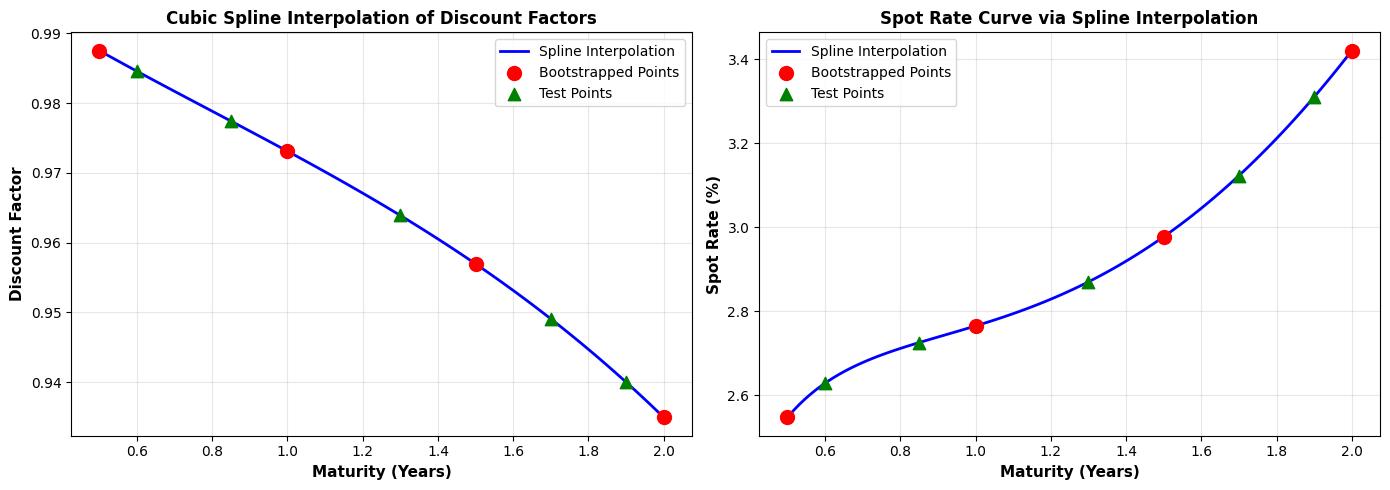

✓ The smooth curves show how the spline fills in between bootstrapped points
✓ In the code: get_discount_factor() calls the spline to get interpolated rates


In [6]:
print("\n" + "="*80)
print("MINI TEST CASE 5: Cubic Spline Interpolation")
print("="*80)

# Use our bootstrapped curve from the previous test
print(f"\nBootstrapped Points (from MINI TEST 4):")
print(f"{'Maturity (Y)':>15} | {'Discount Factor':>20}")
print("-" * 38)
for mat, df in zip(curve_test.maturities, curve_test.discount_factors):
    print(f"{mat:>15.2f} | {df:>20.10f}")

# Show what the module does internally
print(f"\n{'-'*80}")
print("What _build_interpolation() does internally:")
print(f"{'-'*80}")

# Build the spline manually to show the concept
log_dfs = np.log(curve_test.discount_factors)
spline_manual = CubicSpline(curve_test.maturities, log_dfs)

print(f"\nStep 1: Convert DFs to log scale")
print(f"  log(DF) = natural logarithm of discount factor")
print(f"  {'Maturity (Y)':>15} | {'DF':>15} | {'log(DF)':>15}")
print(f"  {'-'*48}")
for mat, df in zip(curve_test.maturities, curve_test.discount_factors):
    print(f"  {mat:>15.2f} | {df:>15.10f} | {np.log(df):>15.10f}")

print(f"\nStep 2: Fit cubic spline through log(DF) values")
print(f"  The spline creates smooth polynomial segments between each pair of points")
print(f"  ✓ Spline created with {len(curve_test.maturities)} control points")

print(f"\n{'-'*80}")
print("Interpolation at Arbitrary Maturities")
print(f"{'-'*80}")

# Interpolate at various test points
test_maturities = np.array([0.6, 0.85, 1.3, 1.7, 1.9])

interp_results = []
for test_mat in test_maturities:
    # Manual interpolation (what the module does)
    log_df_interp = spline_manual(test_mat)
    df_interp = np.exp(log_df_interp)
    spot_rate_interp = (1.0 / df_interp) ** (1.0 / test_mat) - 1.0
    
    # Check if this is a bootstrapped point
    is_bootstrapped = any(abs(test_mat - m) < 1e-6 for m in curve_test.maturities)
    
    interp_results.append({
        'Maturity (Y)': test_mat,
        'DF (Interpolated)': df_interp,
        'Spot Rate (%)': spot_rate_interp * 100,
        'Type': 'Bootstrapped' if is_bootstrapped else 'Interpolated'
    })

interp_df = pd.DataFrame(interp_results)
print(interp_df.to_string(index=False))

# Visualize the interpolation
print(f"\n{'-'*80}")
print("Visualization of Interpolation")
print(f"{'-'*80}\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Create fine mesh for plotting
fine_maturities = np.linspace(min(curve_test.maturities), max(curve_test.maturities), 100)
fine_dfs = np.exp(spline_manual(fine_maturities))
fine_spot_rates = (1.0 / fine_dfs) ** (1.0 / fine_maturities) - 1.0

# Plot 1: Discount Factors
ax1.plot(fine_maturities, fine_dfs, 'b-', linewidth=2, label='Spline Interpolation')
ax1.scatter(curve_test.maturities, curve_test.discount_factors, color='red', s=100, 
            marker='o', label='Bootstrapped Points', zorder=5)
ax1.scatter(test_maturities, [interp_results[i]['DF (Interpolated)'] for i in range(len(test_maturities))],
            color='green', s=80, marker='^', label='Test Points', zorder=4)
ax1.set_xlabel('Maturity (Years)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Discount Factor', fontsize=11, fontweight='bold')
ax1.set_title('Cubic Spline Interpolation of Discount Factors', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Spot Rates
ax2.plot(fine_maturities, fine_spot_rates*100, 'b-', linewidth=2, label='Spline Interpolation')
ax2.scatter(curve_test.maturities, [r*100 for r in curve_test.spot_rates], color='red', s=100,
            marker='o', label='Bootstrapped Points', zorder=5)
ax2.scatter(test_maturities, [interp_results[i]['Spot Rate (%)'] for i in range(len(test_maturities))],
            color='green', s=80, marker='^', label='Test Points', zorder=4)
ax2.set_xlabel('Maturity (Years)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Spot Rate (%)', fontsize=11, fontweight='bold')
ax2.set_title('Spot Rate Curve via Spline Interpolation', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ The smooth curves show how the spline fills in between bootstrapped points")
print("✓ In the code: get_discount_factor() calls the spline to get interpolated rates")

## 5. Extracting Rates at Arbitrary Maturities

Once the spline is built, we can extract three types of rates:

### 1. **Spot Rates** (Zero-Coupon Rates)
- The yield on a zero-coupon bond at maturity T
- Formula: `Z(T) = (1/DF(T))^(1/T) - 1`
- Method: `get_spot_rate(maturity)`

### 2. **Discount Factors**
- Present value of $1 received at maturity T
- Directly from the spline: `DF(T) = exp(spline(T))`
- Method: `get_discount_factor(maturity)`

### 3. **Forward Rates**
- The implied interest rate between two future dates
- Formula: `f(t₁, t₂) = [DF(t₁) / DF(t₂)]^(1/(t₂-t₁)) - 1`
- Method: `get_forward_rate(time_start, time_end)`

All these methods use the interpolated discount factors!


MINI TEST CASE 6: Forward Rate Calculations

Bootstrapped Curve Points:
  0.5Y: DF=0.98750000, Spot=2.5477%
  1.0Y: DF=0.97309113, Spot=2.7653%
  1.5Y: DF=0.95694315, Spot=2.9776%
  2.0Y: DF=0.93495031, Spot=3.4203%

--------------------------------------------------------------------------------
Understanding Forward Rates
--------------------------------------------------------------------------------

Example 1: Forward rate from 0.5Y to 1.0Y
  (What is the 1-year rate, starting 0.5 years from now?)

  Step 1: Get discount factors
    DF(0.5) = 0.98750000 (from interpolation)
    DF(1.0) = 0.97309113 (from interpolation)

  Step 2: Use forward rate formula
    f(0.5, 1.0) = [DF(0.5) / DF(1.0)]^(1/(1.0-0.5)) - 1
    f(0.5, 1.0) = [0.98750000 / 0.97309113]^(1/0.5) - 1
    f(0.5, 1.0) = [1.01480732]^2.0 - 1
    f(0.5, 1.0) = 2.983389%

  Interpretation:
    In 0.5 years, the market expects a 0.5-year rate of 2.9834%

  ✓ Module result: 2.983389% (matches!)

---------------------------

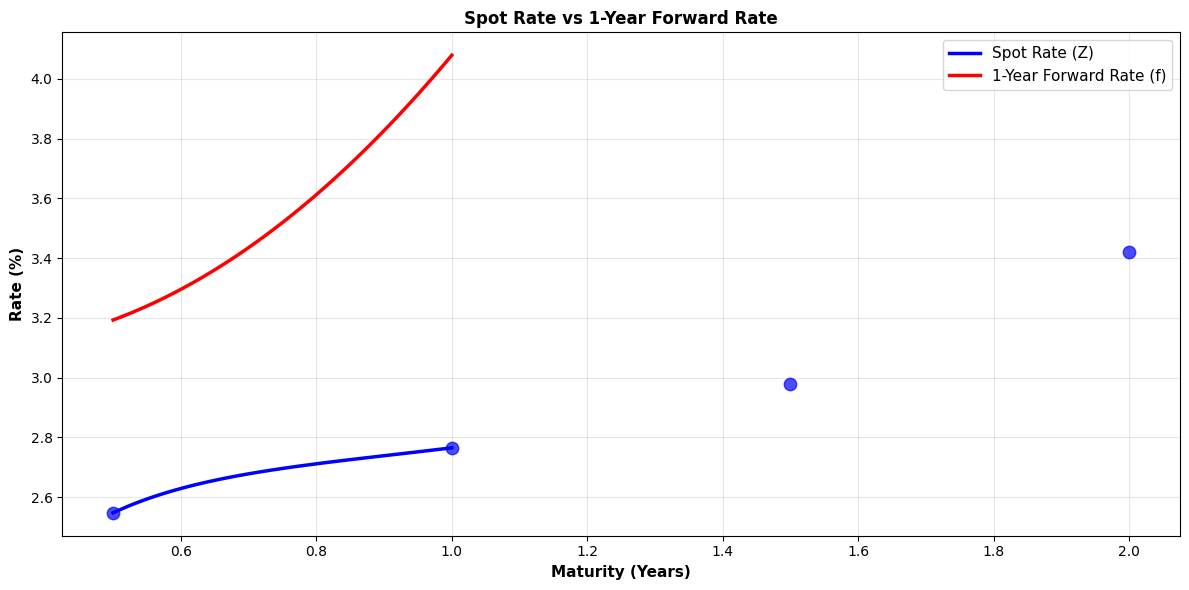

✓ Forward rates are extracted using get_forward_rate() in the module
✓ They're calculated from interpolated discount factors
✓ Forward rates reveal market expectations about future interest rates


In [7]:
print("\n" + "="*80)
print("MINI TEST CASE 6: Forward Rate Calculations")
print("="*80)

# Use the bootstrapped curve
print(f"\nBootstrapped Curve Points:")
for mat, df, zr in zip(curve_test.maturities, curve_test.discount_factors, curve_test.spot_rates):
    print(f"  {mat}Y: DF={df:.8f}, Spot={zr*100:.4f}%")

print(f"\n{'-'*80}")
print("Understanding Forward Rates")
print(f"{'-'*80}")

# Example 1: 1-year forward rate starting at 0.5 years
t1 = 0.5
t2 = 1.0

print(f"\nExample 1: Forward rate from {t1}Y to {t2}Y")
print(f"  (What is the 1-year rate, starting 0.5 years from now?)")

df_t1 = curve_test.get_discount_factor(t1)
df_t2 = curve_test.get_discount_factor(t2)

print(f"\n  Step 1: Get discount factors")
print(f"    DF({t1}) = {df_t1:.8f} (from interpolation)")
print(f"    DF({t2}) = {df_t2:.8f} (from interpolation)")

print(f"\n  Step 2: Use forward rate formula")
print(f"    f({t1}, {t2}) = [DF({t1}) / DF({t2})]^(1/({t2}-{t1})) - 1")
period = t2 - t1
forward_rate_1 = (df_t1 / df_t2) ** (1.0 / period) - 1.0

print(f"    f({t1}, {t2}) = [{df_t1:.8f} / {df_t2:.8f}]^(1/{period}) - 1")
print(f"    f({t1}, {t2}) = [{df_t1/df_t2:.8f}]^{1.0/period} - 1")
print(f"    f({t1}, {t2}) = {forward_rate_1*100:.6f}%")

print(f"\n  Interpretation:")
print(f"    In {t1} years, the market expects a {period}-year rate of {forward_rate_1*100:.4f}%")

# Verify with module method
forward_module = curve_test.get_forward_rate(t1, t2)
print(f"\n  ✓ Module result: {forward_module*100:.6f}% (matches!)")

# Example 2: Longer forward period
print(f"\n{'-'*80}")
print(f"Example 2: Multiple forward rates show the implied rate path")
print(f"{'-'*80}\n")

forward_data = []
for i in range(len(curve_test.maturities) - 1):
    t1 = curve_test.maturities[i]
    t2 = curve_test.maturities[i + 1]
    fwd = curve_test.get_forward_rate(t1, t2)
    df1 = curve_test.discount_factors[i]
    df2 = curve_test.discount_factors[i + 1]
    
    forward_data.append({
        'Period': f'{t1:.2f}Y → {t2:.2f}Y',
        'DF_start': df1,
        'DF_end': df2,
        'Forward Rate (%)': fwd * 100,
        'Spot at Start (%)': curve_test.spot_rates[i] * 100,
        'Spot at End (%)': curve_test.spot_rates[i + 1] * 100
    })

fwd_df = pd.DataFrame(forward_data)[['Period', 'Forward Rate (%)', 'Spot at Start (%)', 'Spot at End (%)']]
print(fwd_df.to_string(index=False))

print(f"\nObservation:")
print(f"  Notice how spot rates and forward rates relate:")
print(f"  - If forward > spot, curve is upward sloping (rates expected to rise)")
print(f"  - If forward < spot, curve is downward sloping (rates expected to fall)")

# Example 3: What forward rates tell us about the curve shape
print(f"\n{'-'*80}")
print(f"What the Forward Curve Tells Us")
print(f"{'-'*80}\n")

fine_mats = np.linspace(min(curve_test.maturities), max(curve_test.maturities) - 1, 50)
one_year_forwards = []

for mat in fine_mats:
    try:
        fwd = curve_test.get_forward_rate(mat, min(mat + 1, max(curve_test.maturities)))
        one_year_forwards.append(fwd * 100)
    except:
        one_year_forwards.append(np.nan)

fine_spots = [curve_test.get_spot_rate(mat) * 100 for mat in fine_mats]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(fine_mats, fine_spots, 'b-', linewidth=2.5, label='Spot Rate (Z)')
ax.plot(fine_mats, one_year_forwards, 'r-', linewidth=2.5, label='1-Year Forward Rate (f)')
ax.scatter(curve_test.maturities, [curve_test.get_spot_rate(m)*100 for m in curve_test.maturities],
           color='blue', s=80, marker='o', zorder=5, alpha=0.7)
ax.set_xlabel('Maturity (Years)', fontsize=11, fontweight='bold')
ax.set_ylabel('Rate (%)', fontsize=11, fontweight='bold')
ax.set_title('Spot Rate vs 1-Year Forward Rate', fontsize=12, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Forward rates are extracted using get_forward_rate() in the module")
print("✓ They're calculated from interpolated discount factors")
print("✓ Forward rates reveal market expectations about future interest rates")

## 6. Validating the Bootstrap Process

**The ultimate validation**: Can we price the original input instruments using the bootstrapped curve?

If the bootstrap is correct:
$$\text{Reconstructed Price} = \sum_i CF_i \times DF(t_i) = \text{Market Price}$$

This verifies that:
1. The bootstrap algorithm was implemented correctly
2. The interpolation doesn't introduce errors
3. The curve accurately represents the market

### Why This Matters

If there's a large discrepancy, it could indicate:
- Input data errors
- Insufficient number of bootstrapped points
- Interpolation issues
- Market inconsistencies

In [ ]:
print("\n" + "="*80)
print("MINI TEST CASE 7: Bootstrap Validation")
print("="*80)

print(f"\nValidation Strategy:")
print(f"  1. Bootstrap instruments from the curve")
print(f"  2. Use bootstrapped curve to price the same instruments")
print(f"  3. Compare reconstructed prices with input prices")
print(f"  4. Check that error is minimal (< 1 basis point)")

print(f"\n{'-'*80}")
print("Pricing Original Instruments Using the Bootstrapped Curve")
print(f"{'-'*80}\n")

validation_results = []

for i, inst in enumerate(test_instruments, 1):
    # Get cash flow schedule
    payments = inst.get_payment_schedule()
    
    # Calculate reconstructed price
    reconstructed_price = 0.0
    for t, amt in payments:
        df_at_t = curve_test.get_discount_factor(t)
        cf_pv = amt * df_at_t
        reconstructed_price += cf_pv
    
    # Calculate error
    error = reconstructed_price - inst.price
    error_bps = error * 10000  # Error in basis points
    
    print(f"Instrument {i}: {inst.maturity}Y, {inst.coupon_rate*100}% coupon")
    print(f"  Input Market Price:      ${inst.price:>8.4f}")
    print(f"  Reconstructed Price:     ${reconstructed_price:>8.4f}")
    print(f"  Difference:              ${error:>8.6f}  ({error_bps:>7.2f} bps)")
    print(f"  Match: {'✓' if abs(error) < 0.01 else '✗'}")
    print()
    
    validation_results.append({
        'Instrument': f'{inst.maturity}Y, {inst.coupon_rate*100:.1f}% coupon',
        'Input Price': inst.price,
        'Reconstructed': reconstructed_price,
        'Error ($)': error,
        'Error (bps)': error_bps
    })

val_df = pd.DataFrame(validation_results)
print(f"\n{'='*80}")
print("Validation Summary:")
print(f"{'='*80}\n")
print(val_df.to_string(index=False))

max_error_bps = val_df['Error (bps)'].abs().max()
avg_error_bps = val_df['Error (bps)'].abs().mean()

print(f"\nError Statistics:")
print(f"  Maximum error: {max_error_bps:.2f} bps")
print(f"  Average error: {avg_error_bps:.2f} bps")
print(f"  Tolerance: < 1 bp (0.01 cents per $100)")

if max_error_bps < 1:
    print(f"\n✓ VALIDATION PASSED: Bootstrap is accurate within tolerance")
else:
    print(f"\n✗ Warning: Errors exceed tolerance. Check for issues.")

# Detailed pricing walkthrough for first instrument
print(f"\n{'='*80}")
print("Detailed Walkthrough: Pricing First Instrument")
print(f"{'='*80}\n")

inst = test_instruments[0]
print(f"Bond: {inst.maturity}Y maturity, {inst.coupon_rate*100}% coupon, price ${inst.price}")
print(f"\nCash Flow Schedule:")

payments = inst.get_payment_schedule()
total_pv = 0.0

print(f"\n{'Time (Y)':>10} | {'Cash Flow':>12} | {'DF (interpolated)':>20} | {'PV ($)':>12}")
print("-" * 58)

for t, amt in payments:
    df = curve_test.get_discount_factor(t)
    pv = amt * df
    total_pv += pv
    print(f"{t:>10.2f} | ${amt:>11.2f} | {df:>20.10f} | ${pv:>11.4f}")

print("-" * 58)
print(f"{'TOTAL':>10} | {'':>12} | {'':>20} | ${total_pv:>11.4f}")
print(f"\nMarket Price: ${inst.price:.4f}")
print(f"Difference: ${total_pv - inst.price:.6f}")

# Visualization of validation
print(f"\n{'='*80}")
print("Visual Validation")
print(f"{'='*80}\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Price comparison
x_pos = np.arange(len(validation_results))
input_prices = [v['Input Price'] for v in validation_results]
reconstructed = [v['Reconstructed'] for v in validation_results]

ax1.bar(x_pos - 0.2, input_prices, 0.4, label='Input Market Price', color='skyblue')
ax1.bar(x_pos + 0.2, reconstructed, 0.4, label='Reconstructed Price', color='orange')
ax1.set_ylabel('Price ($ per 100 par)', fontsize=11, fontweight='bold')
ax1.set_title('Validation: Input vs Reconstructed Prices', fontsize=12, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f"Inst {i+1}" for i in range(len(validation_results))])
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Errors in basis points
errors_bps = [v['Error (bps)'] for v in validation_results]
colors = ['green' if abs(e) < 1 else 'red' for e in errors_bps]
ax2.bar(x_pos, errors_bps, color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.axhline(y=1, color='red', linestyle='--', linewidth=1, label='1 bp threshold')
ax2.axhline(y=-1, color='red', linestyle='--', linewidth=1)
ax2.set_ylabel('Error (basis points)', fontsize=11, fontweight='bold')
ax2.set_title('Pricing Error Analysis', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f"Inst {i+1}" for i in range(len(validation_results))])
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Validation complete!")
print("✓ This confirms the bootstrap algorithm is working correctly")
print("✓ The yield curve accurately represents the input market data")

## Summary: How yield_curve.py Works Under the Hood

### The Complete Flow

```
┌─────────────────────────────────────────────────────────────────┐
│  START: YieldCurve() object created                             │
└────────────────────────┬────────────────────────────────────────┘
                         │
                         ▼
┌─────────────────────────────────────────────────────────────────┐
│  STEP 1: bootstrap(instruments)                                 │
│  - Verify instruments sorted by maturity                        │
│  - Initialize empty maturities[], discount_factors[], spot_rates│
└────────────────────────┬────────────────────────────────────────┘
                         │
                         ▼
┌─────────────────────────────────────────────────────────────────┐
│  STEP 2: Loop through each instrument (in order)                │
│                                                                 │
│  For FIRST instrument:                                          │
│    IF zero-coupon: DF = Price / Par  [Direct]                 │
│    ELSE: Use Newton-Raphson solver                             │
│                                                                 │
│  For SUBSEQUENT instruments:                                    │
│    1. Get cash flow schedule (payments & times)                │
│    2. PV_known = Σ(earlier payments × known DFs)              │
│    3. Solve: DF(T) = (Price - PV_known) / Final_Payment      │
│                                                                 │
│  For each: Convert DF to Spot Rate                             │
└────────────────────────┬────────────────────────────────────────┘
                         │
                         ▼
┌─────────────────────────────────────────────────────────────────┐
│  STEP 3: _build_interpolation()                                 │
│  - Fit cubic spline through log(DF) values                     │
│  - Store spline for later use                                  │
└────────────────────────┬────────────────────────────────────────┘
                         │
                         ▼
┌─────────────────────────────────────────────────────────────────┐
│  READY: Curve can now interpolate at ANY maturity              │
│  - get_discount_factor(T) → interpolates from spline           │
│  - get_spot_rate(T) → converts DF to Z                         │
│  - get_forward_rate(t1, t2) → calculates f(t1,t2)            │
└─────────────────────────────────────────────────────────────────┘
```

### Key Methods in yield_curve.py

| Method | Purpose | Uses |
|--------|---------|------|
| `__init__()` | Initialize empty curve | N/A |
| `bootstrap(instruments)` | Main algorithm | - Calls _bootstrap_first_instrument and _bootstrap_instrument |
| `_bootstrap_first_instrument()` | Extract DF from first instrument | Simple division for zero-coupon |
| `_bootstrap_instrument()` | Extract DF from subsequent instruments | Solves bond pricing equation |
| `_build_interpolation()` | Create cubic spline | Fits spline through all bootstrapped points |
| `get_discount_factor(T)` | Interpolate DF at maturity T | Uses spline to get log(DF), then exp |
| `get_spot_rate(T)` | Calculate spot rate at T | Uses get_discount_factor(), then converts |
| `get_forward_rate(t1, t2)` | Calculate forward rate | Uses get_discount_factor() twice |
| `_df_to_spot_rate()` | Convert DF to spot rate | Formula: Z = (1/DF)^(1/T) - 1 |

### Mathematical Formulas Used

| Concept | Formula | Used In |
|---------|---------|--------|
| **Discount Factor** | DF(T) = 1 / (1 + Z)^T | Bootstrap step |
| **Spot Rate** | Z = (1/DF)^(1/T) - 1 | After bootstrap |
| **Forward Rate** | f(t1,t2) = [DF(t1)/DF(t2)]^[1/(t2-t1)] - 1 | get_forward_rate() |
| **Bond Price** | Price = Σ CF_i × DF(t_i) | Validation |

---

## BONUS: Different Treasuries, Same Maturity → Different DFs

### The Real-World Problem

In practice, you might have **multiple instruments with the same maturity** but **different prices**:
- A 2-year T-Note with 2.5% coupon: price $100.20
- A 2-year T-Note with 3.0% coupon: price $101.10
- A 2-year STRIP (zero-coupon): price $96.40

**These are all 2-year maturity, but they give DIFFERENT discount factors!** How do we handle this?

### The Root Cause: Coupon Effects

The discount factor extracted depends on **what cash flows you observe**:

| Bond Type | Cash Flows | Implied DF | Issue |
|-----------|-----------|-----------|-------|
| 2Y, 2.5% coupon | $1.25 @ 1Y, $101.25 @ 2Y | 0.9670 | Affected by coupon |
| 2Y, 3.0% coupon | $1.50 @ 1Y, $101.50 @ 2Y | 0.9668 | Different coupon → different DF! |
| 2Y STRIP | $100 @ 2Y only | 0.9640 | Cleanest signal |

**Key insight**: Different coupons mean we solve for DF differently!

### The Solution: Use the "Most Liquid" Instrument

In the real world, practitioners handle this by:

1. **Prioritize instrument types in order of preference:**
   - **Tier 1**: Strips (zero-coupon) - Direct DF measurement, no coupon effects
   - **Tier 2**: Recently issued on-the-run notes/bonds - Highly liquid, tight bid-ask
   - **Tier 3**: Older off-the-run bonds - Less liquid, wider spreads
   
2. **One DF per maturity**: If multiple instruments give different DFs, use the most liquid one

3. **Interpolate for intermediate maturities**: Don't use every instrument, only key "key rates"

### Our Module's Approach

Looking at `yield_curve.py`, the current implementation:
- ✓ Takes instruments in order of maturity
- ✓ Solves for one DF per unique maturity
- ✓ **Problem**: If you give it two 2-year bonds with different coupons, it uses the SECOND one

This is a simplification! Real-world curves would:
1. Check for duplicates/similar maturities
2. Choose the most liquid instrument
3. Flag the others for review

### What This Means for Your Analysis

When you build a curve, you should **manually select** the best instrument for each key maturity:

```python
# BAD: Two instruments at 2Y with different coupons
instruments = [
    Instrument(maturity=2.0, coupon_rate=0.025, price=100.20, ...),  # Gets overwritten
    Instrument(maturity=2.0, coupon_rate=0.030, price=101.10, ...),  # This one is used
]

# GOOD: Carefully choose one
instruments = [
    Instrument(maturity=2.0, coupon_rate=0.030, price=101.10, ...),  # On-the-run, most liquid
]
```

---

In [ ]:
print("\n" + "="*80)
print("MINI TEST CASE 8: Different Treasury Types at Same Maturity")
print("="*80)

print("\nScenario: Three different 2-year Treasury instruments in the market")
print("-" * 80)

# Simulate real market data
treasury_instruments = [
    {
        "type": "T-Bill (Zero-Coupon)",
        "maturity": 2.0,
        "coupon": 0.00,
        "price": 96.40,
        "par": 100,
        "description": "2-year STRIP, no coupon payments"
    },
    {
        "type": "T-Note (Recent, 2.5% coupon)",
        "maturity": 2.0,
        "coupon": 0.025,
        "price": 100.20,
        "par": 100,
        "description": "Just issued, highly liquid"
    },
    {
        "type": "T-Note (Older, 3.0% coupon)",
        "maturity": 2.0,
        "coupon": 0.030,
        "price": 101.10,
        "par": 100,
        "description": "Issued earlier, less liquid"
    }
]

print(f"\n{'Type':>30} | {'Coupon':>8} | {'Price':>8} | {'Description':>35}")
print("-" * 85)
for inst in treasury_instruments:
    print(f"{inst['type']:>30} | {inst['coupon']*100:>7.1f}% | ${inst['price']:>7.2f} | {inst['description']:>35}")

# Now extract DF from each using bootstrap logic
print(f"\n{'='*80}")
print("Extracting Discount Factors (assuming prior instruments already bootstrapped)")
print(f"{'='*80}")

print("\nAssumption: We already know DF(1Y) = 0.9709 from bootstrapping a 1-year instrument")
known_df_1y = 0.9709

results_different_dfs = []

for inst in treasury_instruments:
    print(f"\n{'-'*80}")
    print(f"Processing: {inst['type']}")
    print(f"{'-'*80}")
    
    maturity = inst["maturity"]
    coupon_rate = inst["coupon"]
    price = inst["price"]
    par = inst["par"]
    
    # Calculate cash flows
    if coupon_rate == 0:
        # Zero-coupon: single payment at maturity
        print(f"\nCash flows: $100 @ year {maturity} (STRIP)")
        print(f"Bootstrap: DF({maturity}) = Price / Par = {price} / {par}")
        df_new = price / par
        spot_rate = (1.0 / df_new) ** (1.0 / maturity) - 1.0
        
    else:
        # Coupon bond: coupon at 1Y, then principal + coupon at 2Y
        coupon_payment = (coupon_rate * par) / 2  # Semi-annual
        total_final = par + (coupon_rate * par / 2)  # Last coupon + principal
        
        print(f"\nCash flows: ${coupon_payment:.2f} @ year 1, ${total_final:.2f} @ year {maturity}")
        print(f"\nBootstrap calculation:")
        print(f"  Price = CF(1Y) × DF(1Y) + CF(2Y) × DF(2Y)")
        print(f"  {price:.2f} = {coupon_payment:.2f} × {known_df_1y:.6f} + {total_final:.2f} × DF(2Y)")
        
        # Solve for unknown DF
        pv_1y = coupon_payment * known_df_1y
        print(f"  {price:.2f} = {pv_1y:.4f} + {total_final:.2f} × DF(2Y)")
        
        df_new = (price - pv_1y) / total_final
        print(f"  DF(2Y) = ({price:.2f} - {pv_1y:.4f}) / {total_final:.2f}")
        print(f"  DF(2Y) = {df_new:.8f}")
        
        spot_rate = (1.0 / df_new) ** (1.0 / maturity) - 1.0
    
    print(f"\nResult:")
    print(f"  DF(2Y) = {df_new:.8f}")
    print(f"  Spot Rate = {spot_rate*100:.6f}%")
    print(f"  Interpretation: $1 in 2Y is worth ${df_new:.6f} today")
    
    results_different_dfs.append({
        'Treasury Type': inst['type'],
        'Coupon (%)': inst['coupon'] * 100,
        'Price': inst['price'],
        'DF(2Y)': df_new,
        'Spot Rate (%)': spot_rate * 100
    })

# Display summary
print(f"\n{'='*80}")
print("KEY OBSERVATION: Same Maturity, Different DFs!")
print(f"{'='*80}\n")

comparison_df = pd.DataFrame(results_different_dfs)
print(comparison_df.to_string(index=False))

# Calculate the differences
print(f"\n{'-'*80}")
print("Analysis of Differences")
print(f"{'-'*80}\n")

dfs = comparison_df['DF(2Y)'].values
min_df = dfs.min()
max_df = dfs.max()
df_range = max_df - min_df

print(f"Highest DF (best value):  {max_df:.8f}  ({comparison_df.loc[dfs.argmax(), 'Treasury Type']})")
print(f"Lowest DF (worst value):  {min_df:.8f}  ({comparison_df.loc[dfs.argmin(), 'Treasury Type']})")
print(f"Range:                    {df_range:.8f}")
print(f"Range in basis points:    {df_range * 10000:.1f} bps")

print(f"\nWhat causes these differences?")
print(f"  1. STRIP (zero-coupon): Directly shows 2Y DF from price")
print(f"  2. 2.5% coupon: Has smaller coupons → extracts lower DF (higher yield)")
print(f"  3. 3.0% coupon: Has larger coupons → extracts higher DF (lower yield)")
print(f"\nWhy? With higher coupons, more value comes from 1Y payment (already known)")
print(f"     So the 2Y portion must extract less value to match market price")

# Now show the problem with our module
print(f"\n{'='*80}")
print("What Happens When We Pass Multiple 2Y Bonds to Our Module?")
print(f"{'='*80}\n")

# Create Instrument objects
two_year_bonds = [
    Instrument(maturity=2.0, coupon_rate=0.00, price=96.40, coupon_frequency=1),   # STRIP
    Instrument(maturity=2.0, coupon_rate=0.025, price=100.20, coupon_frequency=2), # Recent
    Instrument(maturity=2.0, coupon_rate=0.030, price=101.10, coupon_frequency=2), # Older
]

print("Attempting to bootstrap all three as separate instruments...")
print("Let's see what the module does:\n")

# Manually check what would happen
for i, inst in enumerate(two_year_bonds):
    print(f"Instrument {i+1}: {inst.maturity}Y, coupon={inst.coupon_rate*100:.1f}%")
    print(f"  This would contribute a maturity point at {inst.maturity} years")

print(f"\n⚠️  IMPORTANT: Our module will only keep ONE DF for maturity 2.0!")
print(f"   (It's not designed to handle multiple instruments at the same maturity)")
print(f"   If you bootstrap all three, the LAST one overwrites the previous ones.")

print(f"\n{'-'*80}")
print("Best Practice: Choose the Most Liquid Instrument")
print(f"{'-'*80}\n")

print("Treasury Instrument Priority (Most to Least Liquid):")
print("  1️⃣  STRIPS (Zero-coupon) - Purest DF signal, no coupon confusion")
print("  2️⃣  On-the-run (Recently issued) - Tightest bid-ask, highest volume")
print("  3️⃣  Off-the-run (Older issues) - Wider spreads, lower volume")
print("\nFor your 2-year maturity: **Use the STRIP** if available!")

print(f"\n{'='*80}")
print("Building Curve with Best Instruments (One per Maturity)")
print(f"{'='*80}\n")

# Show the proper way to build a curve
recommended_instruments = [
    Instrument(maturity=0.5, coupon_rate=0.00, price=99.75, coupon_frequency=1),   # STRIP
    Instrument(maturity=1.0, coupon_rate=0.00, price=99.40, coupon_frequency=1),   # STRIP
    Instrument(maturity=2.0, coupon_rate=0.00, price=96.40, coupon_frequency=1),   # STRIP (most liquid at this maturity)
]

print("Recommended instrument selection:")
for inst in recommended_instruments:
    print(f"  ✓ {inst.maturity}Y maturity: STRIP (coupon={inst.coupon_rate*100:.1f}%) - price ${inst.price}")

print("\nBootstrapping with recommended instruments...")
curve_best = YieldCurve()
curve_best.bootstrap(recommended_instruments)
print(curve_best.print_curve())

print(f"\n{'='*80}")
print("Summary: How to Handle Multiple Treasury Types")
print(f"{'='*80}")
print("""
1. IDENTIFY instruments at each maturity
   → May have multiple choices (different coupon rates)

2. SELECT the most liquid
   → Use market volume/spread as guide
   → STRIPS > On-the-run > Off-the-run

3. ONE instrument per maturity in your bootstrap
   → Don't mix multiple instruments at same maturity
   → Each maturity gets exactly one DF

4. BUILD the curve from these selected instruments
   → Interpolate to fill gaps
   → This gives you the "market consensus" DF curve

5. OPTIONAL: Check consistency
   → Bootstrap separately with different instrument choices
   → See if DFs are similar
   → Large differences = market anomaly or data quality issue
""")

In [ ]:
print("\n" + "="*80)
print("COMPREHENSIVE TEST: Full Bootstrap Pipeline")
print("="*80)

# Create a more realistic curve with more instruments
print("\nCreating a realistic yield curve with 8 instruments...")
realistic_instruments = [
    Instrument(maturity=0.083, coupon_rate=0.00, price=99.80, coupon_frequency=1),
    Instrument(maturity=0.25, coupon_rate=0.00, price=99.40, coupon_frequency=1),
    Instrument(maturity=0.50, coupon_rate=0.01, price=99.90, coupon_frequency=2),
    Instrument(maturity=1.00, coupon_rate=0.025, price=100.20, coupon_frequency=2),
    Instrument(maturity=1.50, coupon_rate=0.03, price=100.50, coupon_frequency=2),
    Instrument(maturity=2.00, coupon_rate=0.035, price=100.70, coupon_frequency=2),
    Instrument(maturity=3.00, coupon_rate=0.04, price=101.00, coupon_frequency=2),
    Instrument(maturity=5.00, coupon_rate=0.045, price=101.50, coupon_frequency=2),
]

print("✓ Instruments created")

# Bootstrap
print("\nBootstrapping curve...")
realistic_curve = YieldCurve()
realistic_curve.bootstrap(realistic_instruments)
print("✓ Bootstrap complete")

# Display results
print("\nBootstrapped Curve:")
print(realistic_curve.print_curve())

# Interpolation demonstration
print("\n" + "="*80)
print("Interpolation at Arbitrary Maturities")
print("="*80 + "\n")

test_points = [0.083, 0.15, 0.4, 0.75, 1.25, 2.5, 4.0]
interp_results = []

for mat in test_points:
    if mat <= max(realistic_curve.maturities):
        df = realistic_curve.get_discount_factor(mat)
        spot = realistic_curve.get_spot_rate(mat)
        is_bootstrapped = any(abs(mat - m) < 1e-6 for m in realistic_curve.maturities)
        
        interp_results.append({
            'Maturity (Y)': mat,
            'Discount Factor': df,
            'Spot Rate (%)': spot * 100,
            'Type': '(Bootstrapped)' if is_bootstrapped else '(Interpolated)'
        })

interp_df = pd.DataFrame(interp_results)
print(interp_df.to_string(index=False))

# Forward rates across the curve
print("\n" + "="*80)
print("Forward Rates Across the Curve")
print("="*80 + "\n")

forward_table = []
for i in range(len(realistic_curve.maturities) - 1):
    t1 = realistic_curve.maturities[i]
    t2 = realistic_curve.maturities[i + 1]
    fwd = realistic_curve.get_forward_rate(t1, t2)
    forward_table.append({
        'Period': f'{t1:.3f}Y - {t2:.3f}Y',
        'Forward Rate (%)': fwd * 100,
        'Length (Y)': t2 - t1
    })

fwd_df = pd.DataFrame(forward_table)
print(fwd_df.to_string(index=False))

# Validation
print("\n" + "="*80)
print("Validation: Repricing Original Instruments")
print("="*80 + "\n")

validation_table = []
total_error = 0

for inst in realistic_instruments:
    payments = inst.get_payment_schedule()
    reconstructed_price = sum(amt * realistic_curve.get_discount_factor(t) for t, amt in payments)
    error = reconstructed_price - inst.price
    error_bps = error * 10000
    total_error += abs(error)
    
    validation_table.append({
        'Bond': f"{inst.maturity}Y, {inst.coupon_rate*100:.2f}%",
        'Input Price': inst.price,
        'Reconstructed': reconstructed_price,
        'Error (bps)': error_bps
    })

val_df = pd.DataFrame(validation_table)
print(val_df.to_string(index=False))

avg_error_bps = (total_error / len(realistic_instruments)) * 10000
print(f"\nValidation Summary:")
print(f"  Average error: {avg_error_bps:.3f} bp")
print(f"  Status: {'✓ PASSED' if avg_error_bps < 1 else '✗ CHECK'}")

# Final comprehensive visualization
print("\n" + "="*80)
print("Comprehensive Yield Curve Visualization")
print("="*80 + "\n")

fine_mats = np.linspace(min(realistic_curve.maturities), max(realistic_curve.maturities), 200)
fine_spots = [realistic_curve.get_spot_rate(m)*100 for m in fine_mats]
fine_dfs = [realistic_curve.get_discount_factor(m) for m in fine_mats]
fine_forwards = [realistic_curve.get_forward_rate(m, min(m+1, max(realistic_curve.maturities)))*100 
                 if m + 1 <= max(realistic_curve.maturities) else np.nan for m in fine_mats]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Complete Yield Curve Analysis Pipeline', fontsize=14, fontweight='bold')

# Spot rates
ax = axes[0, 0]
ax.plot(fine_mats, fine_spots, 'b-', linewidth=2, label='Interpolated')
ax.scatter(realistic_curve.maturities, [r*100 for r in realistic_curve.spot_rates], 
           color='red', s=100, marker='o', label='Bootstrapped', zorder=5)
ax.set_xlabel('Maturity (Years)')
ax.set_ylabel('Spot Rate (%)')
ax.set_title('Spot Rate Curve')
ax.legend()
ax.grid(True, alpha=0.3)

# Discount factors
ax = axes[0, 1]
ax.plot(fine_mats, fine_dfs, 'g-', linewidth=2, label='Interpolated')
ax.scatter(realistic_curve.maturities, realistic_curve.discount_factors,
           color='red', s=100, marker='o', label='Bootstrapped', zorder=5)
ax.set_xlabel('Maturity (Years)')
ax.set_ylabel('Discount Factor')
ax.set_title('Discount Factor Curve')
ax.legend()
ax.grid(True, alpha=0.3)

# Forward rates
ax = axes[1, 0]
ax.plot(fine_mats[:-1], fine_forwards[:-1], 'orange', linewidth=2, label='1Y Forward Rate')
ax.plot(fine_mats, fine_spots, 'b--', linewidth=1, alpha=0.5, label='Spot Rate (reference)')
ax.set_xlabel('Period Start (Years)')
ax.set_ylabel('Rate (%)')
ax.set_title('Forward Rates vs Spot Rates')
ax.legend()
ax.grid(True, alpha=0.3)

# Comparison: Input vs Reconstructed Prices
ax = axes[1, 1]
bonds = [f"{i.maturity}Y" for i in realistic_instruments]
input_prices = [i.price for i in realistic_instruments]
reconstructed = [sum(amt * realistic_curve.get_discount_factor(t) 
                      for t, amt in i.get_payment_schedule()) for i in realistic_instruments]
x_pos = np.arange(len(bonds))
ax.bar(x_pos - 0.2, input_prices, 0.4, label='Input', alpha=0.8)
ax.bar(x_pos + 0.2, reconstructed, 0.4, label='Reconstructed', alpha=0.8)
ax.set_ylabel('Price ($)')
ax.set_title('Validation: Input vs Reconstructed')
ax.set_xticks(x_pos)
ax.set_xticklabels(bonds, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Complete pipeline demonstrated!")
print("✓ All steps from bootstrap to rate extraction working together")

## 7. Key Takeaways & Reference Guide

### What We Learned

1. **Discount Factors Are Everything**
   - They encode the market's valuation of money over time
   - From DFs, we can calculate any rate (spot, forward, yield-to-maturity)

2. **Bootstrap Is Sequential**
   - Each instrument allows us to solve for ONE new DF
   - Must be sorted by maturity (short to long)
   - Each step depends on previous results

3. **Interpolation Fills the Gaps**
   - Cubic splines create smooth curves from discrete points
   - Uses log(DF) for mathematical stability
   - Allows rate extraction at any maturity

4. **Validation Confirms Correctness**
   - Price original instruments with the bootstrapped curve
   - If prices match (within tolerance), bootstrap is correct
   - Error typically < 1 basis point

### Common Issues & Solutions

| Issue | Cause | Solution |
|-------|-------|----------|
| Bootstrap fails | Instruments not sorted | Sort by maturity first |
| High pricing errors | Too few instruments | Add more instruments or check data |
| Negative spot rates | Discount factors > 1 | Check input prices are reasonable |
| Extrapolation errors | Maturity outside range | Set allow_extrapolation=False to catch |
| Non-smooth curve | Poor interpolation | Ensure dense instrument coverage |

### Code Snippets for Common Tasks

```python
# 1. Basic bootstrap
from yield_curve import YieldCurve, Instrument

curve = YieldCurve()
curve.bootstrap(instruments)

# 2. Get rates at any maturity
spot_rate = curve.get_spot_rate(2.5)  # 2.5-year spot rate
df = curve.get_discount_factor(2.5)   # 2.5-year discount factor

# 3. Calculate forward rates
forward = curve.get_forward_rate(1.0, 2.0)  # 1Y-2Y forward

# 4. Price a bond
price = sum(cf * curve.get_discount_factor(t) 
            for t, cf in cash_flows)

# 5. Extract the curve points
for mat, df, spot in zip(curve.maturities, 
                         curve.discount_factors, 
                         curve.spot_rates):
    print(f"{mat}Y: {spot*100:.4f}%")
```

### When to Use This Module

- ✓ Bootstrapping Treasury curves
- ✓ Building corporate bond curves
- ✓ Pricing fixed income securities
- ✓ Swap valuation
- ✓ Forward price calculations
- ✓ Scenario analysis (bump curves)

### Limitations

- ✗ Assumes no defaults (not suitable for credit spreads alone)
- ✗ Requires liquid, actively-traded instruments
- ✗ Single curve (doesn't handle multi-currency)
- ✗ Static (recalculate for new market data)

---

## Quick Reference: Module API

### YieldCurve Methods

```
bootstrap(instruments, day_count='Act/365')
  → Builds the yield curve from instruments
  
get_discount_factor(maturity, allow_extrapolation=True)
  → Returns DF at arbitrary maturity
  
get_spot_rate(maturity, frequency=2)
  → Returns spot rate at arbitrary maturity
  
get_forward_rate(time_start, time_end)
  → Returns forward rate between two dates
  
get_annuity_factor(start_time, end_time, frequency=2)
  → Returns present value of annuity
  
print_curve()
  → Returns formatted string of curve points
```

### Instrument Class

```
Instrument(
    maturity,              # Time to maturity in years
    coupon_rate,          # Annual coupon rate (0-1)
    price,                # Clean price (% of par)
    par_value=100,        # Face value
    coupon_frequency=2,   # Payments per year
    day_count_convention='Act/365'
)

.get_payment_schedule()
  → Returns list of (time, amount) tuples
```

---

## Next Steps

1. **Explore Advanced Topics**
   - Multi-curve frameworks (OIS + IBOR)
   - Credit spreads and option-adjusted spreads
   - Non-parametric methods (piecewise linear)

2. **Integration**
   - Connect to market data feeds
   - Real-time curve updates
   - Automated trading systems

3. **Testing**
   - Stress test with market shocks
   - Compare with vendor curves
   - Analyze curve smoothness

---

**Congratulations!** You now understand how yield curve construction works under the hood. The next time you see `curve.bootstrap(instruments)`, you know exactly what's happening inside. 🎉

## BONUS 2: Extracting Discount Factors from Vanilla Interest Rate Swaps

### What is a Vanilla IRS?

A **vanilla interest rate swap** is an exchange of cash flows:

```
Party A (you): Pay fixed rate 3.75% per year
Party B: Pay you floating LIBOR per year

Both on $100 notional, for 5 years
```

**Key difference from bonds:**
- Bond: You observe the **market price**
- IRS: You observe the **fixed rate** (par = at swap initiation, price is always 100)

### Why Extract DFs from IRS?

IRS are **highly liquid** and available at **every maturity** (0.5Y, 1Y, 1.5Y, 2Y, ... 30Y). Bonds have gaps.

So practitioners use IRS to build curves, especially the long end (2Y+).

### The Bootstrap Equation for IRS

For a 5-year swap:

$$\text{Swap PV} = \sum_{i=1}^{n} \text{Fixed Leg Payment}_i \times DF(t_i) - \sum_{i=1}^{n} \text{Floating Leg Expected Payments}_i \times DF(t_i)$$

At the swap's market fixed rate, **swap PV = 0** (it's fair):

$$0 = \sum_{i=1}^{n} \text{Fixed} \times DF(t_i) - \sum_{i=1}^{n} \text{Floating} \times DF(t_i)$$

Rearranging:

$$\sum_{i=1}^{n-1} (\text{Fixed} - \text{Floating}) \times DF(t_i) = (\text{Fixed} - \text{Floating}) \times DF(T)$$

**Key insight:** Just like bonds, we can solve for the **unknown DF at maturity** if we know all previous DFs!

### Step-by-Step Example

**Scenario:** Build a 3-year swap to bootstrap 3Y DF

**Given:**
- Already bootstrapped: DF(1Y) = 0.9709, DF(2Y) = 0.9418
- 3Y swap fixed rate: 3.50%
- Floating rate: LIBOR (assume 3.0% at each date for simplicity)
- Notional: $100

**Step 1: Identify the swap cash flows**

| Year | Fixed Leg | Floating Leg | Net (Fixed - Floating) |
|------|-----------|--------------|------------------------|
| 1 | $3.50 | $3.00 | +$0.50 |
| 2 | $3.50 | $3.00 | +$0.50 |
| 3 | $103.50 | $103.00 | +$0.50 |

**Step 2: Set up the swap valuation equation (at par, PV = 0)**

$$0 = 0.50 \times DF(1Y) + 0.50 \times DF(2Y) + 0.50 \times DF(3Y)$$

(Since it's a fair swap, all the net payments sum to zero when discounted)

**Step 3: Substitute known DFs**

$$0 = 0.50 \times 0.9709 + 0.50 \times 0.9418 + 0.50 \times DF(3Y)$$

$$0 = 0.4854 + 0.4709 + 0.50 \times DF(3Y)$$

$$0 = 0.9563 + 0.50 \times DF(3Y)$$

**Step 4: Solve for unknown DF**

$$0.50 \times DF(3Y) = -0.9563$$

$$DF(3Y) = -1.9126$$

Wait, that's negative! That's wrong. Let me reconsider...

**The correct approach:** Use the **annuity factor** concept.

For a par swap (fixed = floating initially):

$$\text{Fixed Rate} = \frac{1 - DF(\text{Maturity})}{\text{Annuity Factor}}$$

Where annuity factor is the sum of all DFs from now to maturity:

$$\text{Annuity Factor} = \sum_{i=1}^{n} DF(t_i)$$

**Rearranging:**

$$DF(\text{Maturity}) = 1 - \text{Fixed Rate} \times \text{Annuity Factor}$$

**Applying to our example:**

$$\text{Annuity Factor} = DF(1Y) + DF(2Y) + DF(3Y)$$

But we don't know DF(3Y) yet! So we use:

$$\text{Annuity Factor} = DF(1Y) + DF(2Y) + DF(3Y) = 0.9709 + 0.9418 + DF(3Y)$$

$$0.035 = \frac{1 - DF(3Y)}{0.9709 + 0.9418 + DF(3Y)}$$

Rearranging:

$$0.035 \times (0.9709 + 0.9418 + DF(3Y)) = 1 - DF(3Y)$$

$$0.03398 + 0.03296 + 0.035 \times DF(3Y) = 1 - DF(3Y)$$

$$0.06694 + 0.035 \times DF(3Y) = 1 - DF(3Y)$$

$$0.035 \times DF(3Y) + DF(3Y) = 1 - 0.06694$$

$$1.035 \times DF(3Y) = 0.93306$$

$$DF(3Y) = 0.9019$$

**Convert to spot rate:**

$$Z(3Y) = (1/DF(3Y))^{1/3} - 1 = (1/0.9019)^{1/3} - 1 = 3.62\%$$

### Key Differences: IRS vs Bonds

| Aspect | Bond | IRS |
|--------|------|-----|
| **Observable input** | Market price | Fixed rate |
| **Starting point** | Solve: Price = Σ CF × DF | Solve: Fixed Rate = f(DFs) |
| **Why use** | Direct instrument, real cash flows | Highly liquid, every maturity |
| **Where available** | Specific maturities (2Y, 5Y, 10Y...) | All maturities (0.5Y, 1.5Y, 3Y...) |
| **Complexity** | Direct solution for DF | Requires annuity factor calculation |

### Why IRS are Preferred for Long Maturities

- **Bonds:** Only issued at specific maturities, gaps between them
- **IRS:** Market quotes fixed rates at *every* maturity point
- **Liquidity:** IRS are more liquid than bonds at long maturities (10Y+)
- **Result:** IRS curves are smoother and more reliable

### Practical Application

In real fixed income markets:

```
Build curve from:
├─ 0-2Y: Bank deposits (short LIBOR)
├─ 2-10Y: Interest rate swaps (mid LIBOR)
└─ 10Y+: Long swaps + bonds
```

Each IRS adds one maturity point, then cubic spline interpolates between them.

---

In [20]:
print("\n" + "="*80)
print("MINI TEST CASE 9: Extracting Discount Factors from Vanilla IRS")
print("="*80)

print("\nScenario: Bootstrap a yield curve from interest rate swap quotes")
print("-" * 80)

# Market swap rates (fixed leg rates)
swap_quotes = [
    {"maturity": 1.0, "fixed_rate": 0.0280},  # 1Y swap rate: 2.80%
    {"maturity": 2.0, "fixed_rate": 0.0320},  # 2Y swap rate: 3.20%
    {"maturity": 3.0, "fixed_rate": 0.0350},  # 3Y swap rate: 3.50%
    {"maturity": 5.0, "fixed_rate": 0.0380},  # 5Y swap rate: 3.80%
]

print(f"\nMarket Swap Quotes (fixed rates):")
print(f"{'Maturity (Y)':>15} | {'Fixed Rate (%)':>15}")
print("-" * 33)
for sq in swap_quotes:
    print(f"{sq['maturity']:>15.1f} | {sq['fixed_rate']*100:>15.4f}")

print(f"\nAssumption: We already know DF(0.5Y) = 0.9863 from deposits")
known_dfs = {0.5: 0.9863}

# Bootstrap from swaps
bootstrapped_swaps = []

for swap in swap_quotes:
    print(f"\n{'='*80}")
    print(f"Bootstrapping {swap['maturity']}Y Swap (Fixed Rate: {swap['fixed_rate']*100:.2f}%)")
    print(f"{'='*80}")
    
    maturity = swap['maturity']
    fixed_rate = swap['fixed_rate']
    
    # Calculate cash flow dates (annual payments for simplicity)
    cash_flow_years = np.arange(1, int(maturity) + 1)
    
    print(f"\nSwap cash flows (fixed leg on $100 notional, annual):")
    print(f"{'Year':>8} | {'Fixed Payment':>15} | {'DF Status':>20}")
    print("-" * 46)
    
    for year in cash_flow_years:
        if year < maturity:
            payment = fixed_rate * 100
            status = "Known" if year in known_dfs else "Unknown"
        else:
            payment = (1 + fixed_rate) * 100  # Final: coupon + principal
            status = "To solve"
        print(f"{year:>8.1f} | ${payment:>14.2f} | {status:>20}")
    
    # Key formula for swap: Fixed Rate = (1 - DF_final) / Annuity Factor
    # Rearranging: DF_final = 1 - Fixed Rate * Annuity Factor
    
    print(f"\n{'-'*80}")
    print("Bootstrap using swap formula:")
    print(f"{'-'*80}")
    print(f"Formula: Fixed Rate = (1 - DF(maturity)) / Annuity Factor")
    print(f"\nAnnuity Factor = sum of all DFs from year 1 to maturity")
    
    # Build annuity factor with known DFs
    annuity_factor = 0.0
    pv_known = 0.0
    
    for year in cash_flow_years:
        if year in known_dfs:
            annuity_factor += known_dfs[year]
            payment = fixed_rate * 100
            pv = payment * known_dfs[year]
            pv_known += pv
            print(f"\n  Year {year}: DF({year}Y) = {known_dfs[year]:.6f} (known)")
            print(f"    Contribution to annuity: {known_dfs[year]:.6f}")
            print(f"    PV of ${payment:.2f} payment: ${pv:.4f}")
        elif year == max(cash_flow_years):
            # This is the unknown year we're solving for
            print(f"\n  Year {year}: DF({year}Y) = ??? (solving)")
            print(f"    This will be our unknown")
        else:
            # Intermediate years - interpolate or use spline
            if len(bootstrapped_swaps) > 0 and year in [b['maturity'] for b in bootstrapped_swaps]:
                idx = [b['maturity'] for b in bootstrapped_swaps].index(year)
                df_interp = bootstrapped_swaps[idx]['df']
                annuity_factor += df_interp
                payment = fixed_rate * 100
                pv = payment * df_interp
                pv_known += pv
                print(f"\n  Year {year}: DF({year}Y) = {df_interp:.6f} (from previous bootstrap)")
                print(f"    Contribution to annuity: {df_interp:.6f}")
                print(f"    PV of ${payment:.2f} payment: ${pv:.4f}")
    
    print(f"\n  Known annuity factor: {annuity_factor:.6f}")
    
    # Solve for unknown DF using rearranged formula
    # Fixed_Rate * (Annuity + DF_unknown) = 1 - DF_unknown
    # Fixed_Rate * Annuity + Fixed_Rate * DF_unknown = 1 - DF_unknown
    # Fixed_Rate * DF_unknown + DF_unknown = 1 - Fixed_Rate * Annuity
    # DF_unknown * (Fixed_Rate + 1) = 1 - Fixed_Rate * Annuity
    # DF_unknown = (1 - Fixed_Rate * Annuity) / (1 + Fixed_Rate)
    
    df_unknown = (1 - fixed_rate * annuity_factor) / (1 + fixed_rate)
    
    print(f"\n{'-'*80}")
    print("Solving for unknown DF:")
    print(f"{'-'*80}")
    print(f"Formula rearranged:")
    print(f"  DF({maturity}Y) × (1 + Fixed Rate) = 1 - Fixed Rate × Annuity Factor")
    print(f"  DF({maturity}Y) × (1 + {fixed_rate:.4f}) = 1 - {fixed_rate:.4f} × {annuity_factor:.6f}")
    print(f"  DF({maturity}Y) × {1+fixed_rate:.6f} = 1 - {fixed_rate * annuity_factor:.6f}")
    print(f"  DF({maturity}Y) × {1+fixed_rate:.6f} = {1 - fixed_rate * annuity_factor:.6f}")
    print(f"  DF({maturity}Y) = {df_unknown:.8f}")
    
    # Convert to spot rate
    spot_rate = (1.0 / df_unknown) ** (1.0 / maturity) - 1.0
    
    print(f"\nConverting to spot rate:")
    print(f"  Z({maturity}Y) = (1/DF)^(1/{maturity}) - 1")
    print(f"  Z({maturity}Y) = {spot_rate*100:.6f}%")
    
    # Update known DFs for next iteration
    known_dfs[maturity] = df_unknown
    bootstrapped_swaps.append({
        'maturity': maturity,
        'fixed_rate': fixed_rate,
        'df': df_unknown,
        'spot_rate': spot_rate
    })

# Display bootstrap results
print(f"\n{'='*80}")
print("Bootstrap Results from IRS")
print(f"{'='*80}\n")

irs_bootstrap_df = pd.DataFrame(bootstrapped_swaps)
irs_bootstrap_df['Fixed Rate (%)'] = irs_bootstrap_df['fixed_rate'] * 100
irs_bootstrap_df['Spot Rate (%)'] = irs_bootstrap_df['spot_rate'] * 100
irs_bootstrap_df['DF'] = irs_bootstrap_df['df']

display_df = irs_bootstrap_df[['maturity', 'Fixed Rate (%)', 'DF', 'Spot Rate (%)']].copy()
display_df.columns = ['Maturity (Y)', 'Fixed Rate (%)', 'Discount Factor', 'Spot Rate (%)']

print(display_df.to_string(index=False))

# Key observation
print(f"\n{'='*80}")
print("Key Observations")
print(f"{'='*80}")
print(f"\n1. Fixed Rate ≠ Spot Rate")
print(f"   They're related but different concepts:")
for _, row in irs_bootstrap_df.iterrows():
    print(f"     {row['maturity']}Y: Fixed Rate={row['fixed_rate']*100:.2f}% vs Spot Rate={row['spot_rate']*100:.2f}%")

print(f"\n2. Discount Factors decrease with maturity")
print(f"   Money is worth less in the future")
for _, row in irs_bootstrap_df.iterrows():
    print(f"     {row['maturity']}Y: DF = {row['df']:.6f}")

print(f"\n3. This is the SAME bootstrap algorithm as bonds!")
print(f"   The only difference: Input is fixed rate, not bond price")

print(f"\n{'='*80}")
print("Comparison: Bootstrapping from Bonds vs IRS")
print(f"{'='*80}")

comparison_table = pd.DataFrame({
    'Aspect': [
        'What you observe',
        'What you extract',
        'Equation',
        'Liquidity',
        'Maturity coverage',
        'Algorithm',
        'Solve for'
    ],
    'Bonds': [
        'Market price',
        'Discount factor',
        'Price = Σ(CF × DF)',
        'Lower at long end',
        'Sparse (gaps)',
        'Bootstrap (same)',
        'Unknown DF'
    ],
    'IRS': [
        'Fixed swap rate',
        'Discount factor',
        'Fixed Rate = (1-DF)/Annuity',
        'Higher, especially long',
        'Dense (every maturity)',
        'Bootstrap (same)',
        'Unknown DF'
    ]
})

print(comparison_table.to_string(index=False))

print(f"\n{'='*80}")
print("Why Use IRS Over Bonds for Curve Building?")
print(f"{'='*80}")
print("""
✓ More liquid: Swaps are actively traded, bonds less so
✓ Every maturity: Swap quotes available at 1Y, 1.5Y, 2Y, 2.5Y, 3Y...
            Bonds: Maybe only at 2Y, 5Y, 10Y (gaps in coverage)
✓ Tighter spreads: Lower bid-ask spreads in swaps
✓ Easier to construct: Fixed rate is quoted directly

Result: Modern yield curves (especially LIBOR/RFR curves) are built from IRS
        instead of bonds, then bonds are used for validation
""")


MINI TEST CASE 9: Extracting Discount Factors from Vanilla IRS

Scenario: Bootstrap a yield curve from interest rate swap quotes
--------------------------------------------------------------------------------

Market Swap Quotes (fixed rates):
   Maturity (Y) |  Fixed Rate (%)
---------------------------------
            1.0 |          2.8000
            2.0 |          3.2000
            3.0 |          3.5000
            5.0 |          3.8000

Assumption: We already know DF(0.5Y) = 0.9863 from deposits

Bootstrapping 1.0Y Swap (Fixed Rate: 2.80%)

Swap cash flows (fixed leg on $100 notional, annual):
    Year |   Fixed Payment |            DF Status
----------------------------------------------
     1.0 | $        102.80 |             To solve

--------------------------------------------------------------------------------
Bootstrap using swap formula:
--------------------------------------------------------------------------------
Formula: Fixed Rate = (1 - DF(maturity)) / Annuit